In [1]:
import numpy as np
import numba as nb
from numba import cuda,float32,int32, jit
import math
import matplotlib.pyplot as plt
import time

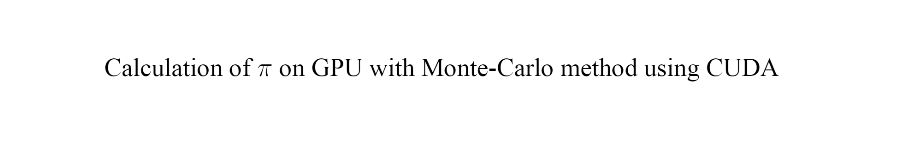

1. Introduction
Calculation of π number is one of the problems frequently used in testing supercomputers and teaching parallel
computing. Algorithms of calculating π number, suitable for parallel processing, could be subdivided into two
classes: iterative and probabilistic. Among iterative methods, the most well-parallelized implementations are
possible for those, that allow to compute separate digits independently, for instance, the Bailey–Borwein–Plouffe
formula (in binary or hexadecimal representation)

Bailey-Borwein-Plouffe formula

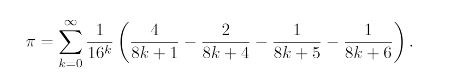

2. Определение задачи
Учитывая количество точек N, сгенерируйте случайное распределение в области (0, 0) - (1, 1) и вычислите число 7
, используя CPU и графический процессор. Результирующие значения должны быть распечатаны вместе со временем выполнения.

Реализация итеративного алгоритма

In [2]:
# Реализация подсчета числа пи с помощью формулы Bailey-Borwein-Plouffe на CPU с помощью библиотеки Numpy
# Примечание большие значения переменной к не могут быть посчитаны в данном алгоритме
# Итеративный метод просчета числа пи

import sys
from decimal import *
from math import factorial

def bbp(n):
    pi = Decimal(0)
    k = 0
    while k < n:
        pi += (Decimal(1)/(16**k))*((Decimal(4)/(8*k+1))-(Decimal(2)/(8*k+4))-(Decimal(1)/(8*k+5))-(Decimal(1)/(8*k+6)))
        k += 1
    return pi
print(bbp(4))

3.141592457567435381837004555


Алгоритм реализации  вероятностного (probobalistic) алгоритма для расчета числа π

1. Сгенерируйте 2 последовательности значений - координаты X и Y
2. Вычислите V = X2 + Y2 для каждой пары значений
3. Если V < 1, верните 1 одному из векторов (X или Y), в противном случае верните 0
4. Выполните сокращение с помощью оператора sum
5. Умножьте результат на 4/N

Реализация алгоритма калькуляции числа π  методом Монте-Карло на CPU

In [3]:
import random

interval = 1000

circle_points = 0
square_points = 0
x_distribution = []
y_distribution = []
start_cpu = time.time()
# Total Random numbers generated= possible x
# values* possible y values
for i in range(interval**2):
    # случайно сгенерированные числа x и у в диапазоне от -1 до 1

    rand_x = random.uniform(-1, 1)
    rand_y = random.uniform(-1, 1)

    x_distribution.append(rand_x)
    y_distribution.append(rand_y)

    # Расстояние точки(x, y) от начала координат
    origin_dist = rand_x**2 + rand_y**2


    # Проверка если сумма квадратов х и у (значение дистанции между х и у) меньше 1 значит  точка находится внутри круга
    if origin_dist <= 1:
        circle_points += 1

    square_points += 1
    # Расчет числа Пи = 4 * (количество точек внутри круга/ количество точек вне круга)

    pi = 4 * circle_points / square_points

end_cpu = time.time() - start_cpu

print(f'Значение числа π {pi}')
print(f'Время выполнения операции на CPU: {end_cpu}')

Значение числа π 3.14384
Время выполнения операции на CPU: 1.2841036319732666


График отображающий часть случайных чисел в диапазоне от -1 до 1 по х и у для CPU

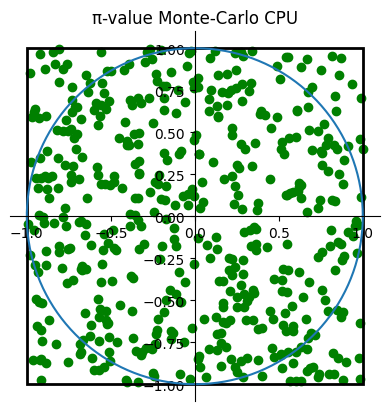

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


theta = np.linspace( 0 , 2 * np.pi , 150 )

radius = 1

a = radius * np.cos( theta )
b = radius * np.sin( theta )

figure, axes = plt.subplots( 1 )

axes.plot( a, b )
axes.set_aspect( 1 )

axes.spines['left'].set_position('zero')
axes.spines['right'].set_color('none')
axes.spines['bottom'].set_position('zero')
axes.spines['top'].set_color('none')

plt.scatter(x_distribution[:500],  y_distribution[:500], color = 'green', zorder=1)

plt.gca ().add_patch (Rectangle((-1,-1),2,2,
 edgecolor='black',
 facecolor='none',
 lw= 2 ))

plt.title( 'π-value Monte-Carlo CPU' )
plt.show()

Для реализации подсчета числа ПИ с помощью GPU будет использоваться модуль numba, в нем реализован аналог библиотеки CURAND - xoroshiro128p, алгоритм представленный в данной библиотеки модуля numba также используется для генерации псевдослучайных чисел на GPU и как следствие для подсчета числа ПИ

In [6]:
from __future__ import print_function, absolute_import

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

start_gpu = time.time()
@cuda.jit
def compute_pi(rng_states, iterations, out):
    """Find the maximum value in values and store in result[0]"""
    thread_id = cuda.grid(1)

    # Compute pi by drawing random (x, y) points and finding what
    # fraction lie inside a unit circle
    # Вычисляем координаты (x, y) с помощь псевдослучайных чисел
    circle_points_gpu = 0
    for i in range(iterations):
        x = xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = xoroshiro128p_uniform_float32(rng_states, thread_id)
        # Определяем какие точки лежат вне круга а какие внутри круга
        if x**2 + y**2 <= 1.0:
            circle_points_gpu += 1

    out[thread_id] = 4.0 * circle_points_gpu / iterations
# Определяем количество нитей на блок и самих блоков
threads_per_block = 64
blocks = 24
#
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)
out = np.zeros(threads_per_block * blocks, dtype=np.float32)

compute_pi[blocks, threads_per_block](rng_states, 1000**2, out)
end_gpu = time.time() - start_gpu
print(f'Время выполнения операции на GPU: {end_gpu}')
print(f'pi: {out.mean()} ')

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 24 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Время выполнения операции на GPU: 0.4483325481414795
pi: 3.1415398120880127 


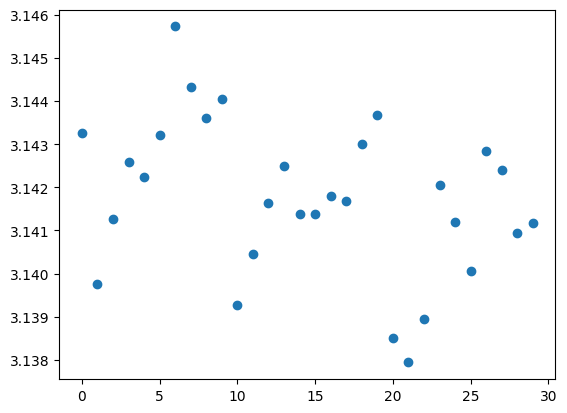

In [ ]:
plt.plot(out[:30], 'o')

Разница между выполнением вероятностного подсчета числа ПИ с помощью метода Монте-Карло CPU/GPU

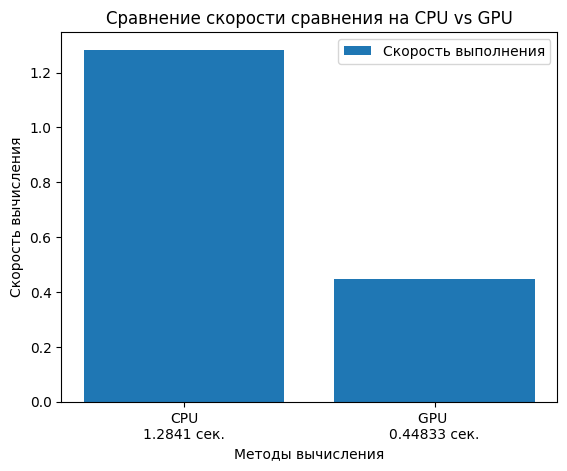


Алгоритм подсчета числа ПИ на CPU медленнее чем на GPU в 2.86417668602558 раза


In [8]:
x_label = [f'CPU\n{round(end_cpu,5)} сек.', f'GPU \n{round(end_gpu, 5)} сек.']
y_label = [end_cpu, end_gpu]

plt.bar(x_label, y_label, label='Скорость выполнения')
plt.xlabel('Методы вычисления')
plt.ylabel('Скорость вычисления')
plt.title('Сравнение скорости сравнения на CPU vs GPU')
plt.legend()
plt.show()
print()
print(f'Алгоритм подсчета числа ПИ на CPU медленнее чем на GPU в {end_cpu/end_gpu} раза')